In [5]:
import numpy as np
import pandas as pd
import torch
from datetime import datetime
import glob
import os
import math
import logomaker

os.chdir('/disk1/jyang4/repos/ALDE/')
#import objectives
#import utils
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr

from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline
# %matplotlib notebook
import seaborn as sns

font = {'size' : 16}
mpl.rc('font', **font)
mpl.rc('lines', linewidth=1.5)
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2

ALL_AAS = ("A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y")

from scipy.stats import norm

def z_score_for_confidence_interval(confidence_level):
    # Ensure the confidence level is between 0 and 100
    if confidence_level <= 0 or confidence_level >= 1:
        raise ValueError("Confidence level must be between 0 and 1 (exclusive)")

    # Convert confidence level to a two-tailed probability
    p = 1 - (1 - confidence_level) / 2

    # Use the percent point function (ppf) of the standard normal distribution
    z_score = norm.ppf(p)

    return z_score

def plot_logo(batch, name):
  dfs = []
  for i in range(1, 6):
      temp = batch.groupby(f'AA{i}').count()
      temp[i] = temp.mean(axis=1)
      temp = temp[[i]]
      temp.index.name = ''
      temp = temp.copy().T
      dfs.append(temp)
  
  df = pd.concat(dfs)
  #replace nan with 0
  df = df.fillna(0)
  #normalize rows to 1
  df = df.div(df.sum(axis=1), axis=0)
  df

  # create Logo object
  AAs_logo = logomaker.Logo(df,
                            color_scheme='weblogo_protein',
                            #font_name='Arial',
                            vpad=.15,
                            figsize=(3, 2.5),
                          #   baseline_width=.8,
  )

  # additional styling using Logo methods
  AAs_logo.style_spines(visible=False)

  # style using Axes methods
  AAs_logo.ax.set_ylim([0, 1])
  AAs_logo.ax.set_ylabel('frequency', labelpad=0)
  AAs_logo.ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
  AAs_logo.ax.set_xticks([1,2,3,4, 5])
  AAs_logo.ax.set_title(name)

  return

In [6]:
# X = torch.tensor(np.load('/disk1/jyang4/repos/data/GB1_ESM2_4site.npy')).double()
# X = torch.reshape(X, (X.shape[0], -1))
# torch.save(X, '/disk1/jyang4/repos/data/GB1_ESM2_x.pt')

# Analyzing Computational Simulations on GB1 and TrpB

### Analyzing Optimization Trajectories
For looking at the effect of different models, encodings, and acquisition functions

In [2]:
df = pd.read_csv('all_results.csv')
#repalce DNN with DNN_ENSEMBLE
# df['Model'] = df['Model'].replace('BOOSTING_ENSEMBLE', 'Boosting Ensemble')
# df['Model'] = df['Model'].replace('GP_BOTORCH', 'GP')
# df['Model'] = df['Model'].replace('DNN_ENSEMBLE', 'DNN Ensemble')
# df['Model'] = df['Model'].replace('DKL_BOTORCH', 'DKL')
# df['Acquisition'] = df['Acquisition'].replace('Random', 'GREEDY')
#df = df[df['Model'] == 'DNN_ENSEMBLE']

#for every row, duplicate the row but change mean
df_lower = df.copy()
df_lower['Mean'] = df_lower['Mean'] - df_lower['Std']
df_upper = df.copy()
df_upper['Mean'] = df_upper['Mean'] + df_upper['Std']
df = pd.concat([df, df_lower, df_upper])
df = df.reset_index(drop=True)

### Add in the single round results?

In [17]:
df[df['Model'] == 'Random']

,Protein,Encoding,Model,Acquisition,Timestep,Mean,Std
4620,GB1,Random,Random,GREEDY,96,0.297451,0.017492
4621,GB1,Random,Random,GREEDY,97,0.297451,0.017492
4622,GB1,Random,Random,GREEDY,98,0.297451,0.017492
4623,GB1,Random,Random,GREEDY,99,0.297671,0.017455
4624,GB1,Random,Random,GREEDY,100,0.301626,0.017376
...,...,...,...,...,...,...,...
99325,TrpB,Random,Random,GREEDY,476,0.596383,0.011919
99326,TrpB,Random,Random,GREEDY,477,0.596383,0.011919
99327,TrpB,Random,Random,GREEDY,478,0.596383,0.011919
99328,TrpB,Random,Random,GREEDY,479,0.596383,0.011919


/tmp/ipykernel_181584/3921612351.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = df2[df2['Protein'] == protein][df2['Encoding'].isin([encoding])] #'Random
/tmp/ipykernel_181584/3921612351.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = df2[df2['Protein'] == protein][df2['Encoding'].isin([encoding])] #'Random
/tmp/ipykernel_181584/3921612351.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = df2[df2['Protein'] == protein][df2['Encoding'].isin([encoding])] #'Random
/tmp/ipykernel_181584/3921612351.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = df2[df2['Protein'] == protein][df2['Encoding'].isin([encoding])] #'Random
/tmp/ipykernel_181584/3921612351.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = df2[df2['Protein'] == protein][df2['Encoding'].isin([encoding])] #'Ra

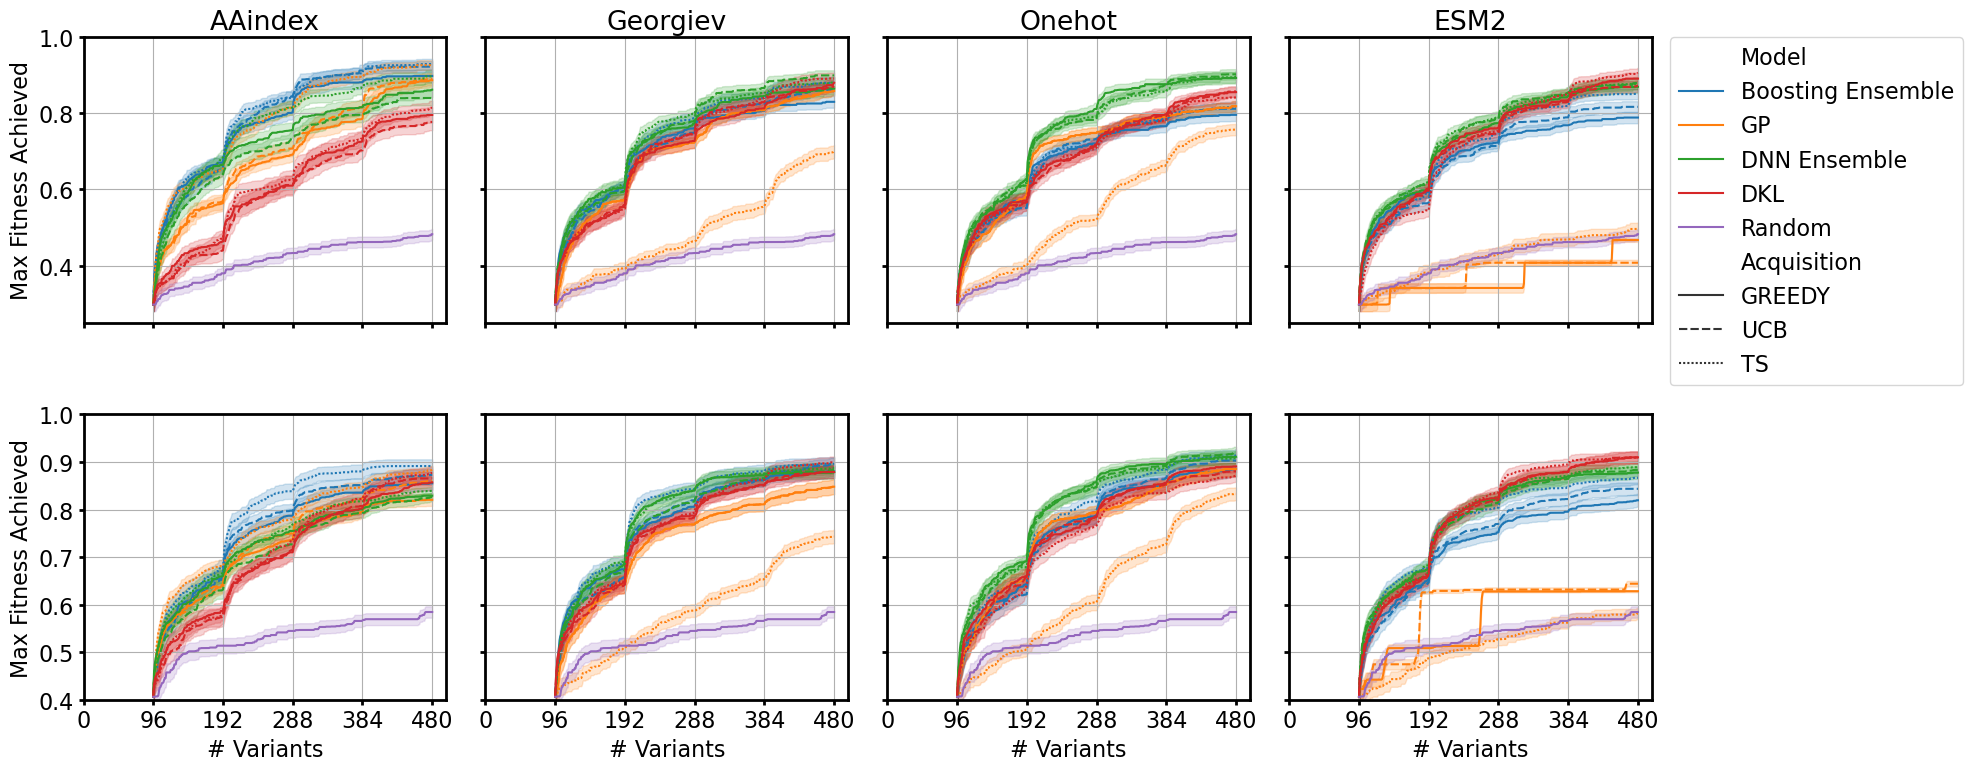

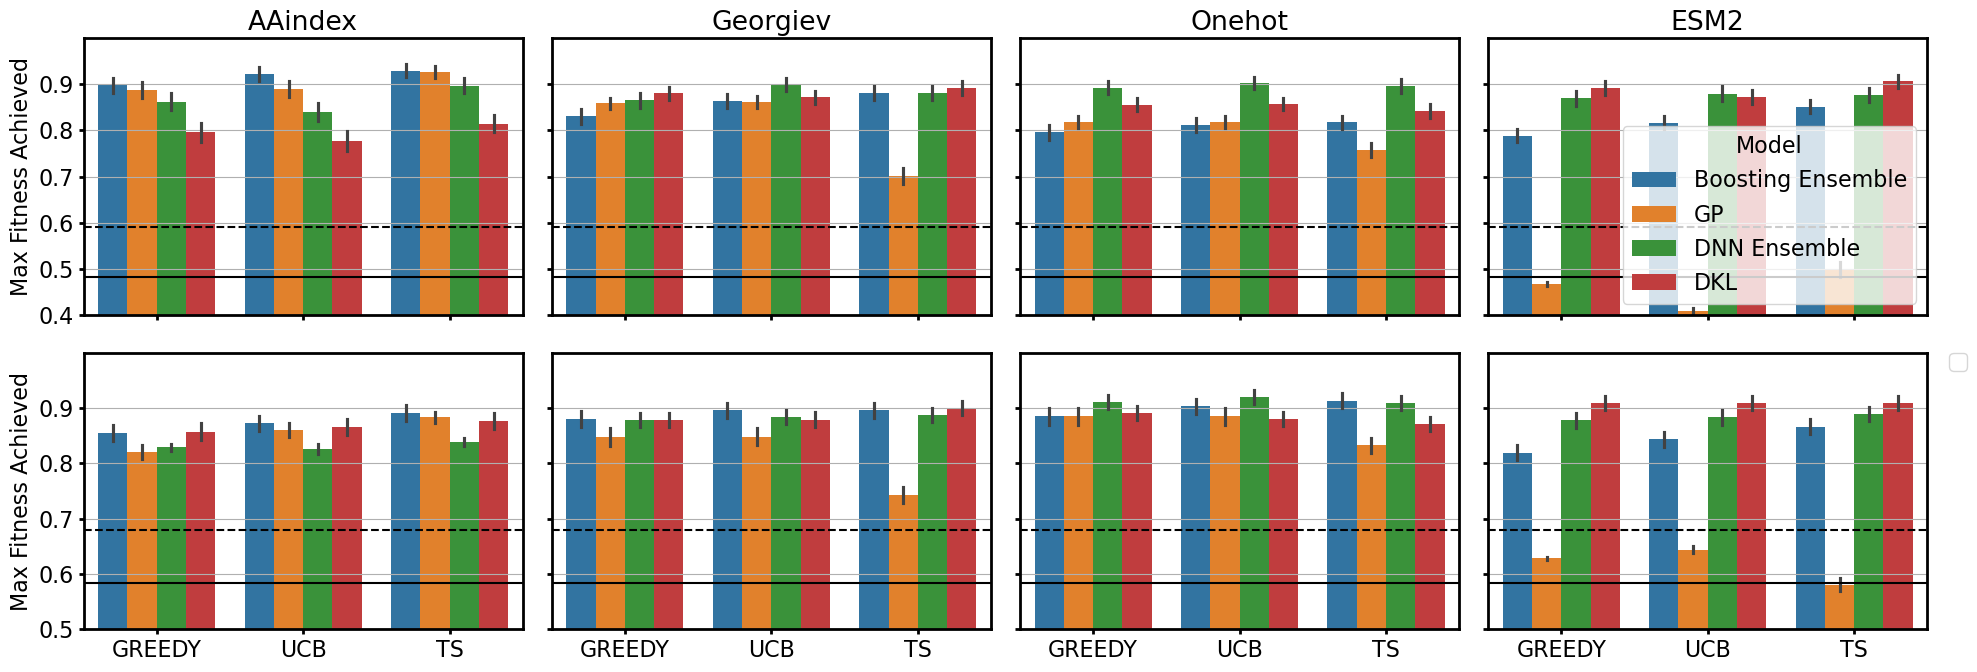

In [27]:
plt.figure(1, figsize=(20, 8))
plt.figure(2, figsize=(20, 7))
i = 0

#model_order = ['BOOSTING_ENSEMBLE', 'GP_BOTORCH', 'DNN_ENSEMBLE', 'DKL_BOTORCH']
model_order = ['Boosting Ensemble', 'GP', 'DNN Ensemble', 'DKL', 'Random'] #'RANDOM'
model_order2 = ['Boosting Ensemble', 'GP', 'DNN Ensemble', 'DKL']
acq_order = ['GREEDY', 'UCB' , 'TS']
encoding_dict = {'AA': 'AAindex', 'georgiev': 'Georgiev', 'onehot': 'Onehot', 'ESM2': 'ESM2'}

for protein in ['GB1', 'TrpB']:
    for encoding in ['AA', 'georgiev', 'onehot', 'ESM2']:

        df2 = df.copy()
        df2['Encoding'] = df2['Encoding'].replace('Random', encoding)
    
        subset = df2[df2['Protein'] == protein][df2['Encoding'].isin([encoding])] #'Random
        #subset df[df['Protein'] == 'GB1'][df['Encoding'] == 'Random']

        plt.figure(1)
        plt.subplot(2, 4, i + 1)
        #ax.fill_between(df.Timestep, df.Mean - df.STD, df.Mean + df.STD, alpha=0.2)
        if i == 3:
            ax = sns.lineplot(data=subset, x="Timestep", y="Mean", hue='Model', style="Acquisition", hue_order= model_order, style_order = acq_order, errorbar=('pi', 100))
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=16)
        else: 
            ax = sns.lineplot(data=subset, x="Timestep", y="Mean", hue='Model', style="Acquisition", hue_order= model_order, style_order = acq_order, errorbar=('pi', 100), legend=False)

        plt.xticks(np.arange(0, 480 + 96, 96))
        if protein == 'GB1':
            plt.ylim([0.25, 1])
        else:
            plt.ylim([0.4, 1])
        plt.grid()
        plt.ylabel('Max Fitness Achieved')
        plt.xlabel('# Variants')
        if i <= 3: 
            ax.set_xticklabels([])
            ax.set(xlabel=None)
            plt.title(encoding_dict[encoding])
            
        if i != 0 and i != 4:
            ax.set_yticklabels([])
            ax.set(ylabel=None)

        
        plt.figure(2)
        plt.subplot(2, 4, i + 1)
        last = subset[subset['Timestep'] == 480]
        #print(last)
        final_random = last[last['Model'] == 'Random']['Mean'].mean()
        #print(final_random)
        last = last[last['Model'] != 'Random']

        dictionary = dict(zip(last['Mean'], last['Std']))
        
        def get_std(mean):
            return(0.8, 0.95)
            #return (mean - dictionary[mean], mean + dictionary[mean])
        
        if i == 3:
            ax = sns.barplot(data=last, x='Acquisition', y='Mean', hue='Model', order= acq_order, hue_order=model_order2, errorbar=('pi', 100))
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=16)
        else:
            ax = sns.barplot(data=last, x='Acquisition', y='Mean', hue='Model', legend=False, order= acq_order, hue_order=model_order2, errorbar=('pi', 100))

        ax.yaxis.grid(True)
        plt.xlabel('')
        if protein == 'GB1':
            plt.ylim([0.4, 1])
            plt.yticks(np.arange(0.4, 1, 0.1))
            plt.axhline(y=0.59, color='black', linestyle='--') #DE single step greedy walk result
        else:
            plt.ylim([0.5, 1])
            plt.yticks(np.arange(0.5, 1, 0.1))
            plt.axhline(y=0.68, color='black', linestyle='--') #DE single step greedy walk result
        plt.axhline(y=final_random, color= 'k', linestyle='-')

        plt.ylabel('Max Fitness Achieved')

        if i <= 3: 
            ax.set_xticklabels([])
            plt.title(encoding_dict[encoding])
            
        if i != 0 and i != 4:
            ax.set_yticklabels([])
            ax.set(ylabel=None)

        #plt.xticks(rotation=60) 

        i += 1


plt.figure(1)
plt.tight_layout()
plt.savefig('trajectories.svg')

plt.figure(2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=16)
plt.tight_layout()
plt.savefig('barplot_maxfit.svg')

Baseline for one round of MLDE

In [10]:
df = pd.read_csv('all_results_oneround.csv')
#for every row, duplicate the row but change mean
df_lower = df.copy()
df_lower['Mean'] = df_lower['Mean'] - df_lower['Std']
df_upper = df.copy()
df_upper['Mean'] = df_upper['Mean'] + df_upper['Std']
df = pd.concat([df, df_lower, df_upper])
df = df.reset_index(drop=True)

In [9]:
plt.figure(2, figsize=(20, 7))
i = 0

#model_order = ['BOOSTING_ENSEMBLE', 'GP_BOTORCH', 'DNN_ENSEMBLE', 'DKL_BOTORCH']
model_order = ['Boosting Ensemble', 'GP', 'DNN Ensemble', 'DKL', 'Random'] #'RANDOM'
model_order2 = ['Boosting Ensemble', 'GP', 'DNN Ensemble', 'DKL']
acq_order = ['GREEDY', 'UCB' , 'TS']
encoding_dict = {'AA': 'AAindex', 'georgiev': 'Georgiev', 'onehot': 'Onehot', 'ESM2': 'ESM2'}

for protein in ['GB1', 'TrpB']:
    for encoding in ['AA', 'georgiev', 'onehot', 'ESM2']: 
        
        df2 = df.copy()
        df2['Encoding'] = df2['Encoding'].replace('Random', encoding)
        subset = df2[df2['Protein'] == protein][df2['Encoding'].isin([encoding])] 

        plt.figure(2)
        plt.subplot(2, 4, i + 1)
        last = subset[subset['Timestep'] == 480]
        #print(last)
        final_random = last[last['Model'] == 'Random']['Mean'].mean()
        #print(final_random)
        last = last[last['Model'] != 'Random']

        dictionary = dict(zip(last['Mean'], last['Std']))
        
        def get_std(mean):
            return(0.8, 0.95)
            #return (mean - dictionary[mean], mean + dictionary[mean])
        
        if i == 3:
            ax = sns.barplot(data=last, x='Acquisition', y='Mean', hue='Model', order= acq_order, hue_order=model_order2, errorbar=('pi', 100), legend=False)
        else:
            ax = sns.barplot(data=last, x='Acquisition', y='Mean', hue='Model', legend=False, order= acq_order, hue_order=model_order2, errorbar=('pi', 100))

        ax.yaxis.grid(True)
        plt.xlabel('')
        if protein == 'GB1':
            plt.ylim([0.4, 1])
            plt.yticks(np.arange(0.4, 1, 0.1))
            plt.axhline(y=0.59, color='black', linestyle='--') #DE single step greedy walk result
        else:
            plt.ylim([0.5, 1])
            plt.yticks(np.arange(0.5, 1, 0.1))
            plt.axhline(y=0.68, color='black', linestyle='--') #DE single step greedy walk result
        plt.axhline(y=final_random, color= 'k', linestyle='-')

        plt.ylabel('Max Fitness Achieved')

        if i <= 3: 
            ax.set_xticklabels([])
            plt.title(encoding_dict[encoding])
            
        if i != 0 and i != 4:
            ax.set_yticklabels([])
            ax.set(ylabel=None)

        #plt.xticks(rotation=60) 

        i += 1

plt.figure(2)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=16)
plt.tight_layout()
plt.savefig('barplot_maxfit_baseline.svg')

NameError: name 'df' is not defined

<Figure size 2000x700 with 0 Axes>

### How calibrated is the uncertainty from the models?

/tmp/ipykernel_374679/1850305515.py:121: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  relevant_sigma = fitness_df[fitness_df[fitness_col] >= lower][fitness_df[fitness_col] <= upper]['sigma']
/tmp/ipykernel_374679/1850305515.py:121: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  relevant_sigma = fitness_df[fitness_df[fitness_col] >= lower][fitness_df[fitness_col] <= upper]['sigma']
/tmp/ipykernel_374679/1850305515.py:121: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  relevant_sigma = fitness_df[fitness_df[fitness_col] >= lower][fitness_df[fitness_col] <= upper]['sigma']
/tmp/ipykernel_374679/1850305515.py:121: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  relevant_sigma = fitness_df[fitness_df[fitness_col] >= lower][fitness_df[fitness_col] <= upper]['sigma']
/tmp/ipykernel_374679/1850305515.py:121: UserWarning: Boolean Series key will be reindexed to match Data

<Figure size 1600x800 with 0 Axes>

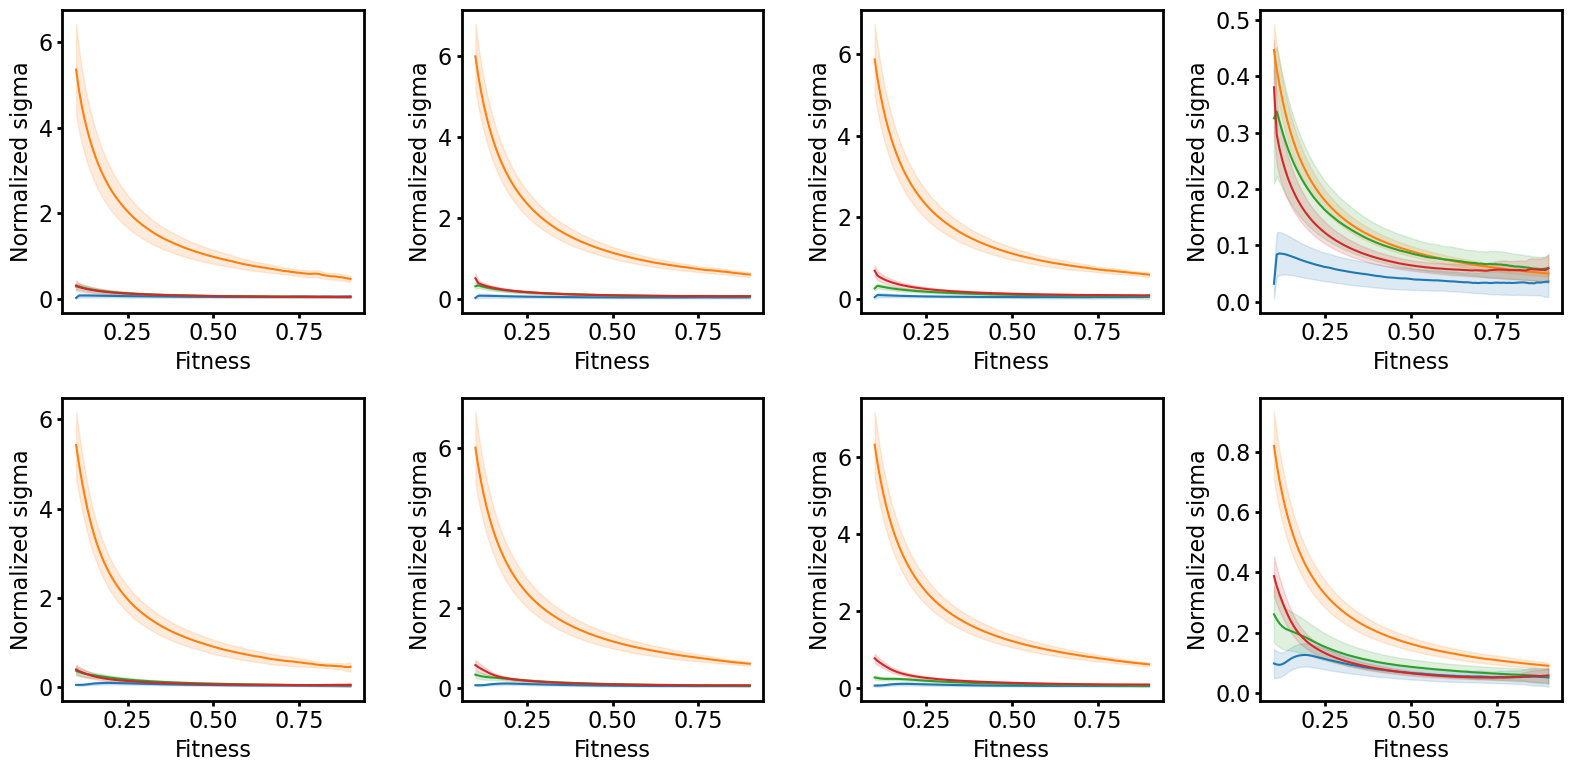

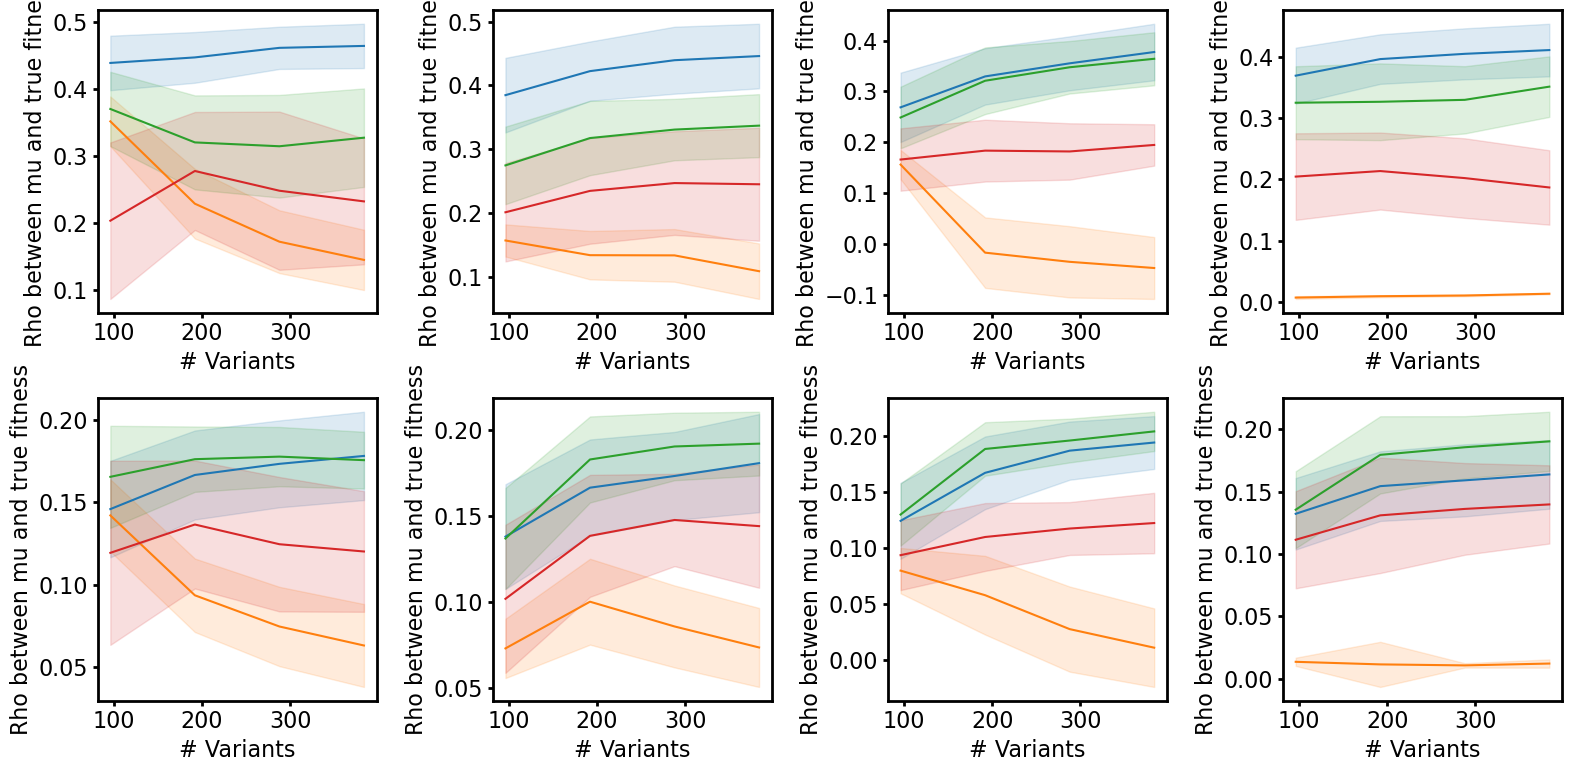

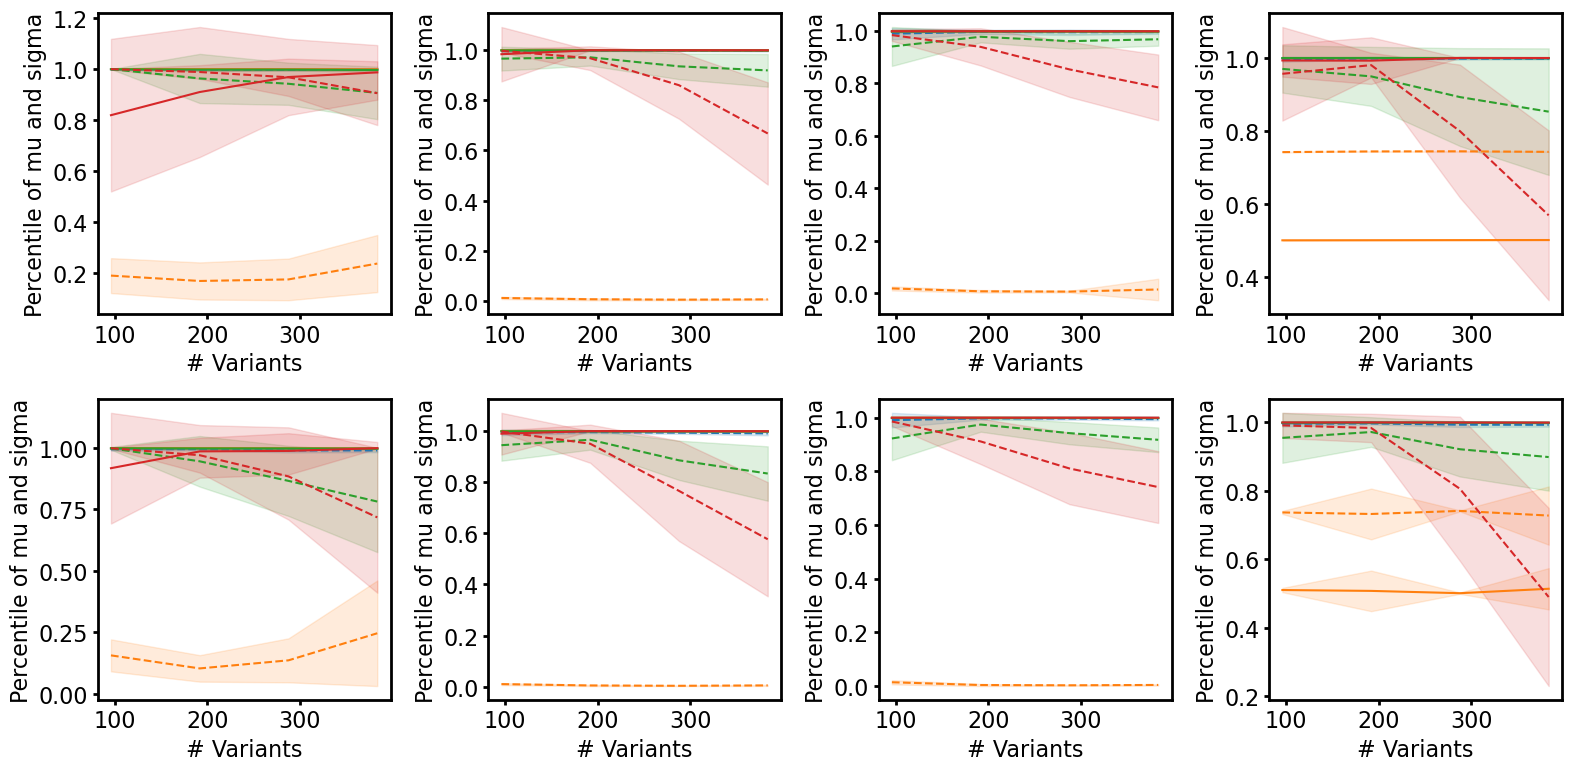

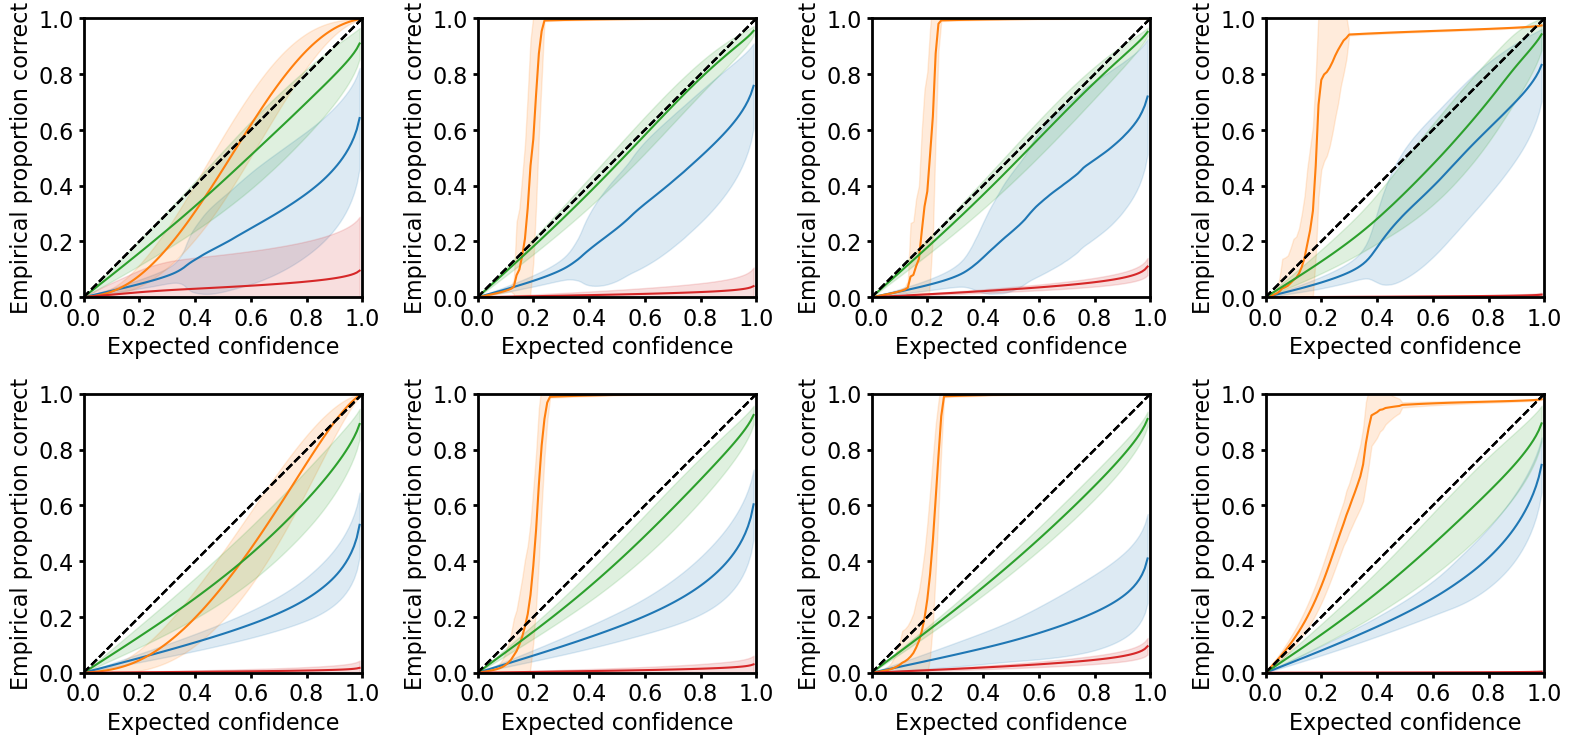

In [2]:
# plt.figure(1, figsize=(12, 6))
# plt.figure(2, figsize=(12, 6))

plt.figure(1, figsize=(16, 8))
plt.figure(2, figsize=(16, 8))
plt.figure(3, figsize=(16, 8))
plt.figure(4, figsize=(16, 8))
plt.figure(5, figsize=(16, 8))

j = 0

model_order = ['BOOSTING_ENSEMBLE', 'GP_BOTORCH', 'DNN_ENSEMBLE', 'DKL_BOTORCH'] #'RANDOM'

dimension_dict1 = {'AA': '16', 'georgiev': '76', 'onehot': '80', 'ESM2': '5120'}
dimension_dict2 = {'AA': '8', 'georgiev': '30', 'onehot': '30', 'ESM2': '50'}

model_dict = {'BOOSTING_ENSEMBLE': 'Boosting Ensemble', 'GP_BOTORCH': 'GP', 'DNN_ENSEMBLE': 'DNN Ensemble', 'DKL_BOTORCH': 'DKL', 'RANDOM': 'Random'}
encoding_dict = {'AA': 'AAindex', 'georgiev': 'Georgiev', 'onehot': 'Onehot', 'ESM2': 'ESM2'}

summary_df = pd.DataFrame(columns=['Protein', 'Encoding', 'Model', 'rho', 'miscalibration_area', 'MAE'])

for protein in ['GB1', 'TrpB']:
    if protein == 'GB1':
        fitness_df = pd.read_csv('/disk1/jyang4/repos/data/GB1_fitness.csv')
        fitness_col = 'fit'
    elif protein == 'TrpB':
        fitness_df = pd.read_csv('/disk1/jyang4/repos/data/TrpB_fitness.csv')
        fitness_col = 'fitness'

    for encoding in ['AA', 'georgiev', 'onehot', 'ESM2']: #['AA', 'georgiev', 'onehot', 'ESM2']
        prefix = f'{protein}_{encoding}'

        for model in model_order:
            if model in ['GP_BOTORCH', 'BOOSTING_ENSEMBLE']:
                dimension = dimension_dict1[encoding]
            else:
                dimension = dimension_dict2[encoding]
            directory = f'{model}-DO-0-RBF-UCB-[{dimension}, 1]_'
            directory_prefix = f'/disk1/jyang4/repos/DKBO-MLDE/results/redo/{prefix}/{directory}'

            n_repeats =70
            n_points= 99

            all_ys = np.zeros((n_points, n_repeats))
            all_maes = np.zeros((len(fitness_df), n_repeats))
            all_mus = np.zeros((4, n_repeats))
            all_sigmas = np.zeros((4, n_repeats))
            all_rhos = np.zeros((4, n_repeats))

            all_ys2= np.zeros((n_points, n_repeats))

            steps = [96, 192, 288, 384]

            for i in range(n_repeats):
                y = torch.load(directory_prefix + str(i+1) + 'y.pt')
                indices = torch.load(directory_prefix + str(i+1) + 'indices.pt')
                fitness_df[fitness_col] = fitness_df[fitness_col]/fitness_df[fitness_col].max()

                for k, step in enumerate(steps):
                    
                    #normalizer = y[:step].max()
                    sigma = torch.load(directory_prefix + str(i+1) + '_' + str(step) + 'sigma.pt')
                    mu = torch.load(directory_prefix + str(i+1) + '_' + str(step) + 'mu.pt')
                    
                    fitness_df['sigma'] = sigma
                    fitness_df['mu'] = mu
                    
                    fitness_df['normalized_sigma'] = abs(sigma/mu)
                    fitness_df['UCB'] = fitness_df['mu'] + 2 * fitness_df['sigma']
                    fitness_df['LCB'] = fitness_df['mu'] - 2 * fitness_df['sigma']
                    fitness_df['calibrated'] = (fitness_df[fitness_col] > fitness_df['LCB']) & (fitness_df[fitness_col] < fitness_df['UCB'])
                    fitness_df['normalized_error'] = abs((fitness_df['mu'] - fitness_df[fitness_col])/fitness_df['mu'])
                    
                    fitness_df['MAE'] = abs(fitness_df['mu'] - fitness_df[fitness_col])
                    
                    fitness_df['sigma percentile'] = fitness_df['sigma'].rank(pct = True)
                    fitness_df['mu percentile'] = fitness_df['mu'].rank(pct = True)
                    
                    #print(fitness_df['calibrated'].sum()/len(fitness_df))
                    
                    new_queries = fitness_df.iloc[indices[step:step + 96]]
                    all_mus[k, i] = new_queries['mu percentile'].mean()
                    all_sigmas[k, i] = new_queries['sigma percentile'].mean()
                    all_rhos[k, i] = spearmanr(fitness_df['mu'], fitness_df[fitness_col])[0]

                    subset = fitness_df.iloc[indices[:384]]
                    # new_queries['Step'] = step
                    # if step == 96:
                    #     queries_uq = new_queries
                    # else:
                    #     queires_uq = pd.concat([queries_uq, new_queries])

                #calibration curves for the last set
                confidences = np.linspace(0.01, 0.99, n_points)
                y = []
                miscalibration_area = 0
                for confidence in confidences:
                    z_score = z_score_for_confidence_interval(confidence)
                    #fitness_df = nearby_df only check the similar variants
                    #fitness_df = subset
                    fitness_df['UCB_temp'] = fitness_df['mu'] + z_score * fitness_df['sigma']
                    fitness_df['LCB_temp'] = fitness_df['mu'] - z_score * fitness_df['sigma']
                    fitness_df['calibrated_temp'] = (fitness_df[fitness_col] > fitness_df['LCB_temp']) & (fitness_df[fitness_col] < fitness_df['UCB_temp'])
                    temp_y = fitness_df['calibrated_temp'].sum()/len(fitness_df)
                    y.append(temp_y)
                    miscalibration_area += abs(confidence - temp_y) #approximate area as a sum of rectangles
                miscalibration_area /= n_points

                all_ys[:, i] = y

                sorted = fitness_df.sort_values(by='sigma')
                all_maes[:, i] = sorted['MAE'].values
                rho = spearmanr(sorted['sigma'], sorted['MAE'])[0]
                summary_df.loc[len(summary_df.index)] = [protein, encoding_dict[encoding], model, rho, miscalibration_area, sorted['MAE'].mean()]

                fitnesses = np.linspace(0.1, 0.9, n_points)
                y2 = []
                for l, fitness in enumerate(fitnesses):
                    lower = fitness - 0.1
                    upper = fitness + 0.1
                    relevant_sigma = fitness_df[fitness_df[fitness_col] >= lower][fitness_df[fitness_col] <= upper]['sigma']
                    mean_sigma = relevant_sigma.mean()/fitness #normalize to the fitness value
                    y2.append(mean_sigma)

                all_ys2[:, i] = y2
            
            plt.figure(5)
            plt.subplot(2, 4, j + 1)
            
            mean = all_ys2.mean(axis=1)
            p5 = plt.plot(fitnesses, mean, '-')
            sem = all_ys2.std(axis=1)
            plt.fill_between(fitnesses, mean - sem, mean + sem, color=p5[-1].get_color(), alpha=.15)
            plt.tight_layout()
            plt.xlabel('Fitness')
            plt.ylabel('Normalized sigma')
            
            plt.figure(4)
            plt.subplot(2, 4, j + 1)
            
            mean = all_rhos.mean(axis=1)
            p4 = plt.plot(steps, mean, '-')
            sem = all_rhos.std(axis=1)
            plt.fill_between(steps, mean - sem, mean + sem, color=p4[-1].get_color(), alpha=.15)
            plt.tight_layout()
            plt.xlabel('# Variants')
            plt.ylabel('Rho between mu and true fitness')
            
            plt.figure(3)
            plt.subplot(2, 4, j + 1)

            mean = all_mus.mean(axis=1)
            p3 = plt.plot(steps, mean, '-')
            sem = all_mus.std(axis=1)
            plt.fill_between(steps, mean - sem, mean + sem, color=p3[-1].get_color(), alpha=.15)

            mean = all_sigmas.mean(axis=1)
            p3 = plt.plot(steps, mean, '--', color=p3[-1].get_color())
            sem = all_sigmas.std(axis=1)
            plt.fill_between(steps, mean - sem, mean + sem, color=p3[-1].get_color(), alpha=.15)
            plt.tight_layout()
            plt.xlabel('# Variants')
            plt.ylabel('Percentile of mu and sigma')

            plt.figure(1)
            plt.subplot(2, 4, j + 1)
            ax = plt.gca()
            ax.set_aspect('equal')
            mean = all_ys.mean(axis=1)
            p = plt.plot(confidences, mean, '-')
            sem = all_ys.std(axis=1)
            plt.fill_between(confidences, mean - sem, mean + sem, color=p[-1].get_color(), alpha=.15)
            plt.plot([0,1], [0,1], '--k')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.xticks(np.arange(0, 1.1, 0.2))
            plt.yticks(np.arange(0, 1.1, 0.2))
            plt.xlabel('Expected confidence')
            plt.ylabel('Empirical proportion correct')
            plt.tight_layout()
            if i <= 3: 
                ax = plt.gca()
                ax.set_xticklabels([])
                ax.set(xlabel=None)

            # plt.figure(2)
            # plt.subplot(2, 4, j + 1)
            # ax = plt.gca()
            # mean = all_maes.mean(axis=1)
            # percentiles = np.linspace(0, 1, len(mean))
            # p = plt.plot(percentiles, mean, '-')
            # sem = all_maes.std(axis=1)
            # plt.fill_between(percentiles, mean - sem, mean + sem, color=p[-1].get_color(), alpha=.15)
            # plt.yscale("log")
            # # plt.plot([0,1], [0,1], '--k')
            # # plt.xlim([0, 1])
            # plt.ylim([0, 1])
            # # plt.xticks(np.arange(0, 1.1, 0.2))
            # # plt.yticks(np.arange(0, 1.1, 0.2))
            # plt.xlabel('Percentile of Uncertainty')
            # plt.ylabel('MAE') 
            # plt.tight_layout() 
            # if i <= 3: 
            #     ax = plt.gca()
            #     ax.set_xticklabels([])
            #     ax.set(xlabel=None)
            
        j += 1
        
        # if j == 3:
        #     plt.legend(model_order, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
plt.figure(1)
plt.tight_layout()
plt.savefig('calibration_curves.svg')

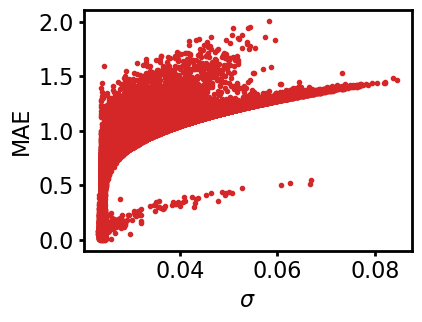

In [31]:
plt.figure(figsize=(4.5, 3.5))
plt.plot(sorted['sigma'], sorted['MAE'], '.', color='tab:red')
plt.xlabel('$\sigma$')
plt.ylabel('MAE')
plt.tight_layout()
plt.savefig('uncertainty_vs_mae.jpg', dpi=500)

/tmp/ipykernel_182612/3628722294.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0, 1])
/tmp/ipykernel_182612/3628722294.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0, 1])


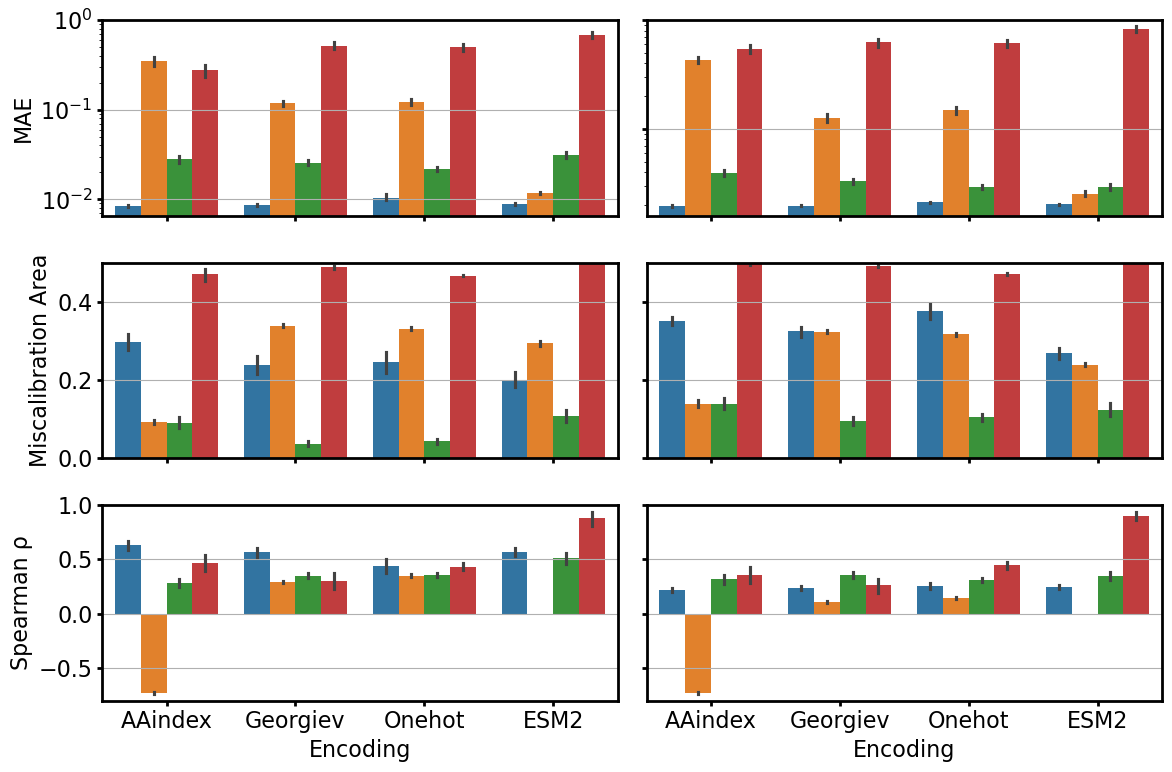

In [13]:
i = 0
plt.figure(figsize = (12, 8))
#plt.figure(figsize = (12, 9))
for metric in ['MAE', 'miscalibration_area', 'rho']:
    for protein in ['GB1', 'TrpB']:
        i += 1
        plt.subplot(3, 2, i)
        ax = sns.barplot(data=summary_df[summary_df['Protein'] == protein], x='Encoding', y=metric, hue='Model', hue_order=model_order, legend=False)

        if metric == 'rho':
            plt.ylabel('Spearman \u03C1')
            plt.ylim([-0.8, 1])
        elif metric == 'miscalibration_area':
            plt.ylabel('Miscalibration Area')
            plt.ylim([0, 0.5])
        elif metric == 'MAE':
            ax.set_yscale("log")
            plt.ylim([0, 1])
        ax.yaxis.grid(True)
        if i <= 4: 
            ax.set_xticklabels([])
            ax.set(xlabel=None)
        if i == 2 or i ==4 or i ==6: 
            ax.set_yticklabels([])
            ax.set(ylabel=None)

plt.tight_layout()
plt.savefig('uncertainty_calibration_bars.svg')

### Check the log likelihood during training and compare between models
What are reasonable values for this number?

In [2]:
#can check this by watching the terminal
#was indeed lower negative log likelihood for the DK compared to GP


# Analysis of Wet-Lab ParPgb Campaign

## Before the Optimization Campaign

### Look at Singles

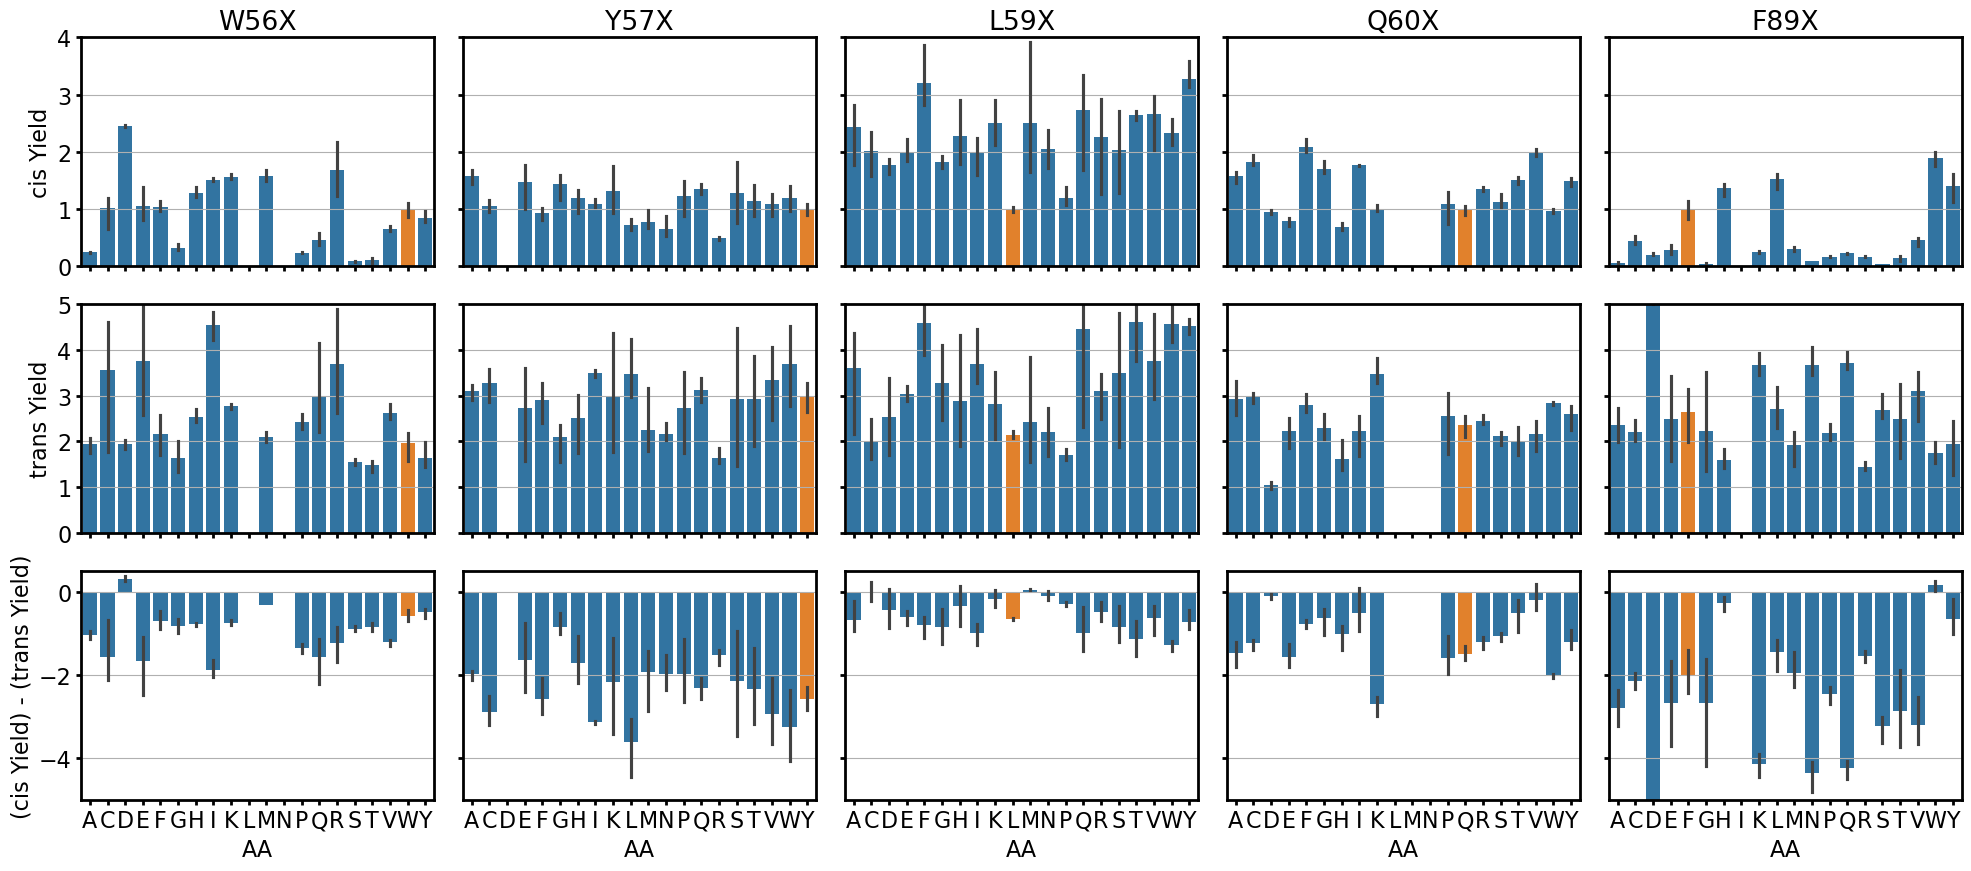

In [5]:
parent_residues = ['W', 'Y', 'L', 'Q', 'F']
number = ['56', '57', '59', '60', '89']
i = 0
plt.figure(figsize=(20, 9))
map_dict = {}
#make an empty nested dictionary

combos = []
NormIso1 = []
NormIso2 = []

for column in ['NormIso1','NormIso2', 'Diff']: #['NormIso1', 'NormIso2', 'Diff']
    map_dict[column] = {}
    for sheet, residue in zip(range(5), parent_residues):
        map_dict[column][sheet] = {}
        plt.subplot(3, 5, i+1)
        i += 1
        data = pd.read_excel('/disk1/jyang4/repos/data/from_StARDUST/ParPgb/5site_ravi_carbene/RL-7-50_SSM_AllData_56X-60X+89X.xlsx', sheet_name=sheet) 
        #replace Sterile with []
        data['AA'] = data['AA'].apply(lambda x: x.replace('Sterile', '[]'))
        data['WT'] = data['AA'] == residue
        
        #normalize everything to mean of WT of NormIso1, skip if you want selectivity
        if column != 'Diff':
            data[column] = data[column]/data[data['WT']]['NormIso1'].mean()

        #barplot with the resude of interest colored
        if i<=5:
            plt.title(residue + number[sheet] + 'X')
        

        data['Diff'] = data['NormIso1'] - data['NormIso2']
        ax = sns.barplot(x='AA', y=column, data=data, hue ='WT', order=ALL_AAS)
        ax.yaxis.grid(True)
        
        for aa in ALL_AAS:
            mean = data[data['AA'] == aa][column].mean()
            # if np.isnan(mean):
            #     mean = 1
            map_dict[column][sheet][aa] = mean

            residues = parent_residues.copy()
            residues[sheet] = aa
            combo = ''.join(residues)
            #todo plot the one that doesn't appear in a different color
            
            if column == 'NormIso1':
                combos.append(combo)
                NormIso1.append(mean)
            elif column == 'NormIso2':
                NormIso2.append(mean)           

        #remove legend
        if column == 'Diff':
            plt.ylabel('(cis Yield) - (trans Yield)')
            plt.ylim(-5, 0.5)
        if column == 'NormIso1':
            plt.ylim(0, 4)
            plt.ylabel('cis Yield')
        if column == 'NormIso2':
            plt.ylim(0, 5)
            plt.ylabel('trans Yield')
        
        if i != 1 and i != 6 and i != 11:
            ax.set_yticklabels([])
            ax.set(ylabel=None)
        if i <= 10:
            ax.set_xticklabels([])
            ax.set(xlabel=None)
        
        plt.legend([],[], frameon=False)
plt.tight_layout()
plt.savefig('singles_fitness.svg')
dict = {'Combo': combos, 'NormIso1': NormIso1, 'NormIso2': NormIso2,}
singles_df = pd.DataFrame(dict)
singles_df = singles_df.groupby('Combo').mean().reset_index()

### Look at 5site Library

Sequences about 340/384, tossed out about 30 excess parents from minion, then left with 216 unique sequences with no stop codons

In [4]:
fitness_df = pd.read_csv('/disk1/jyang4/repos/data/Pgb_fitness.csv', index_col=0)
fitness_df

,Combo,Unnamed: 0,Alignment Probability,Alignment Count,Column,StdArea,Iso1Area,Iso2Area,num_wells,EVMutation,EVMutation Rank,Triad Score,Triad Rank,NormIso1_recomb,NormIso2_recomb,NormIso1_recomb_rank,NormIso2_recomb_rank,NormIso1,NormIso2,Diff
0,FRMNY,7.0,0.624151,339.0,2.0,484.0,3398.0,567.0,1,-28.982647,69.0,-648.97722,33,NaN,NaN,NaN,NaN,4.586441,0.765307,3.821134
1,SAFRY,2.0,0.755508,128.0,8.0,487.0,3778.0,963.0,1,-31.842763,118.0,-646.67160,48,0.835324,1.329356,20.0,70.0,5.067932,1.291800,3.776133
2,GIDLY,165.0,0.086459,197.0,5.0,501.0,2485.0,428.0,1,-31.299863,112.0,-642.32678,97,0.000000,0.000000,155.5,155.5,3.449043,0.594040,2.855002
3,TSGMY,28.0,0.244922,154.0,3.0,497.0,3058.0,1062.0,1,-29.967584,90.0,-645.07324,60,NaN,NaN,NaN,NaN,4.019563,1.395937,2.623626
5,TNMPY,331.0,0.867393,241.0,11.0,484.0,1788.0,367.0,1,-33.636411,146.0,-633.74115,162,0.262932,0.495441,52.0,132.0,3.260248,0.669190,2.591058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,LQSGA,353.0,0.172635,238.0,12.0,474.0,276.0,2725.0,1,-32.559556,130.0,-642.98517,84,0.000000,0.000000,155.5,155.5,0.513877,5.073604,-4.559727
186,QYKGD,286.0,0.001800,177.0,4.0,442.0,107.0,2436.0,1,-29.577335,80.0,-641.25164,113,0.390436,4.028886,38.0,2.0,0.213644,4.863887,-4.650243
213,PCLTD,251.0,0.717479,513.0,1.0,506.0,88.0,3513.0,1,-38.626022,216.0,-629.35627,187,0.075245,2.350554,87.0,19.0,0.120283,4.801761,-4.681477
190,NNVER,306.0,0.687294,230.0,7.0,509.0,106.0,2847.0,1,-34.952975,176.0,-640.64290,120,NaN,NaN,NaN,NaN,0.183788,4.936261,-4.752473


Fitness distribution for both isomers

(-0.2533966063696007,
 5.321328733761614,
 -0.2749404928506328,
 5.773750349863289)

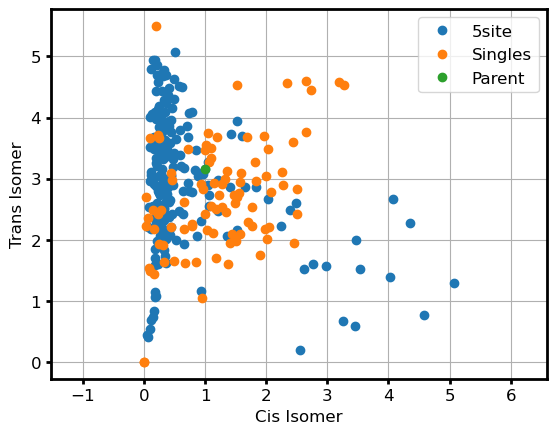

In [5]:
plt.plot(fitness_df['NormIso1'], fitness_df['NormIso2'], 'o')
plt.plot(singles_df['NormIso1'], singles_df['NormIso2'], 'o')
parent_df = fitness_df[fitness_df['Combo'] == 'WYLQF']

plt.plot(parent_df['NormIso1'], parent_df['NormIso2'], 'o')
plt.xlabel('Cis Isomer')
plt.ylabel('Trans Isomer')
plt.grid()
plt.legend(['5site', 'Singles', 'Parent'])
plt.axis('equal')

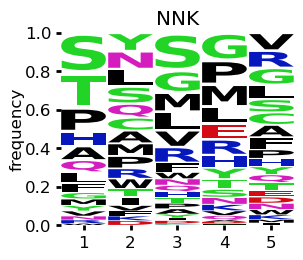

In [6]:
# plt.figure(figsize=(20, 6))
for i in [1]:
    for j in  [0]:
        sites = 5
        labels = ['AA1', 'AA2', 'AA3', 'AA4', 'AA5']
        if j == 0:
            #batch = merged_cleaned[merged_cleaned['NormIso1'] > 0] # can also use 1
            batch = fitness_df
        
        for l in range(sites):
            batch['AA' + str(l+1)] = batch['Combo'].apply(lambda x: x[l])

        # for k, label  in enumerate(labels):
        #     plt.subplot(2, 5, k + 5*j + 1)
        #     batch[label].value_counts().plot(kind="bar")
        #     plt.xticks(rotation=0)
        #     #sns.countplot(x=label, data=batch)
#plt.tight_layout()
plot_logo(batch, 'NNK')

### Look at Correlation to Zeroshot Scores and Recombination of Singles

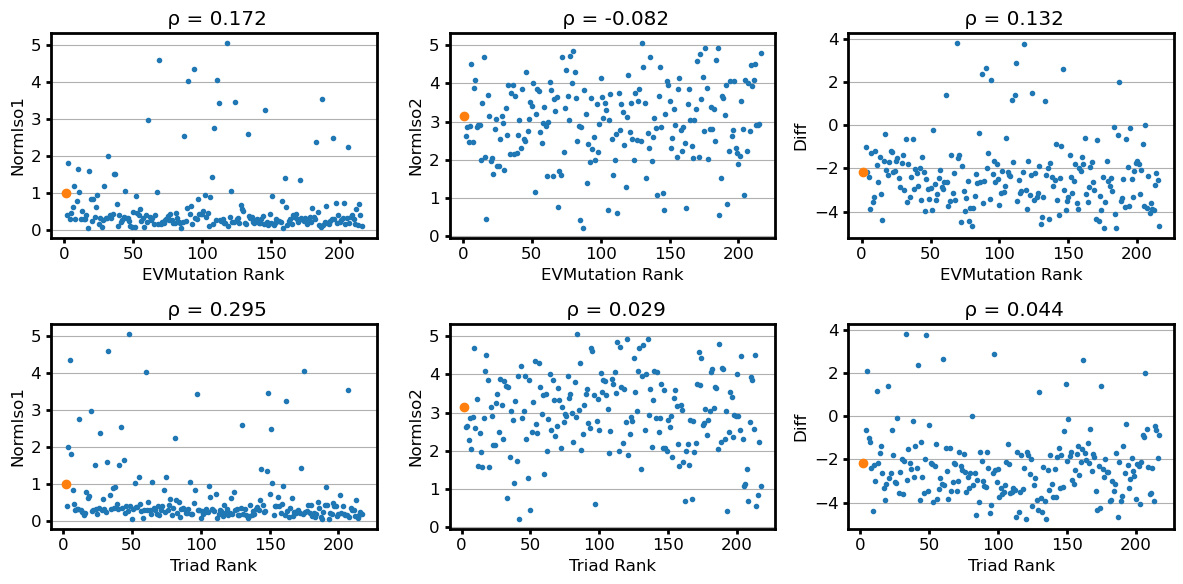

In [7]:
plt.figure(figsize=(12, 6))
for i,zs in enumerate(['EVMutation Rank', 'Triad Rank']):
    for j, reaction in enumerate(['NormIso1', 'NormIso2', 'Diff']):

        # fitness = merged[reaction]
        # fitness[fitness == np.inf] = np.min(fitness)
        # merged['norm_fit'] = fitness/np.nanmax(fitness)

        #zs = 'Triad Rank'
        
        #zs = 'Naive Rank'
        #merged['Naive Rank'] = merged['indep_fit'].rank(ascending = False)

        WT_combo = 'WYLQF'

        WT_df = fitness_df[fitness_df['Combo'] == WT_combo]

        plt.subplot(2,3, 3*i + j+1)
        plt.plot(fitness_df[zs], fitness_df[reaction], '.')
        plt.plot(WT_df[zs], WT_df[reaction], 'o')
        plt.title(' \u03C1 = ' + str(round(spearmanr(-fitness_df[zs].values, fitness_df[reaction].values)[0],3)))
        plt.grid(axis='y')
        #plt.xlim(0, 96)
        plt.xlabel(zs)
        plt.ylabel(reaction)
plt.tight_layout()

Correlation between EVMutation and Triad

SignificanceResult(statistic=0.5524428726229175, pvalue=1.1720170803151053e-18)

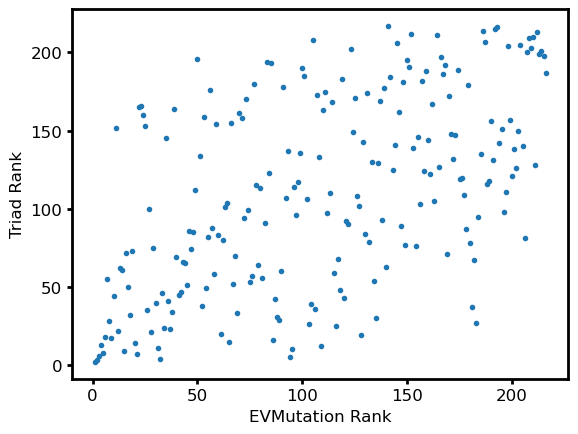

In [8]:
plt.plot(fitness_df['EVMutation Rank'], fitness_df['Triad Rank'], '.')
plt.xlabel('EVMutation Rank')
plt.ylabel('Triad Rank')
spearmanr(fitness_df['EVMutation Rank'].values, fitness_df['Triad Rank'].values)

How well do the singles predict variants in the 5site?

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

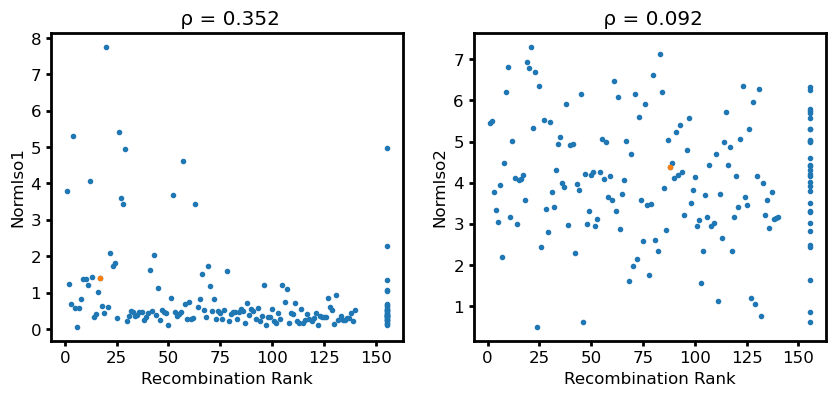

In [23]:
plt.figure(figsize=(10, 4))
for i, column in enumerate(['NormIso1', 'NormIso2']):
    plt.subplot(1, 2, i+1)
    fitness_df2 = fitness_df.dropna(subset=[column+ '_recomb_rank'])
    WT =  fitness_df2[fitness_df2['Combo'] == 'WYLQF']
    plt.plot(fitness_df2[column+ '_recomb_rank'], fitness_df2[column], '.')
    plt.plot(WT[column+ '_recomb_rank'], WT[column], '.')
    spearman_value = spearmanr(-fitness_df2[column +'_recomb_rank'].values, fitness_df2[column].values)[0]
    plt.title(' \u03C1 = ' + str(round(spearman_value,3)))
    plt.xlabel('Recombination Rank')
    plt.ylabel(column)
plt.tight_layout

## 1st Round of Predictions

/tmp/ipykernel_751551/529708846.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['AA' + str(l+1)] = batch['Combo'].apply(lambda x: x[l])
/tmp/ipykernel_751551/529708846.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['AA' + str(l+1)] = batch['Combo'].apply(lambda x: x[l])
/tmp/ipykernel_751551/529708846.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

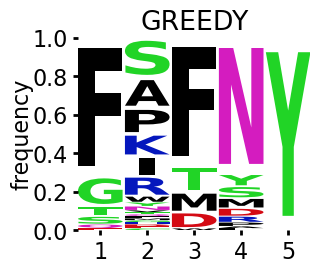

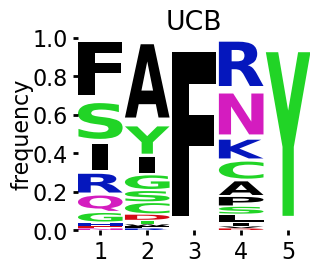

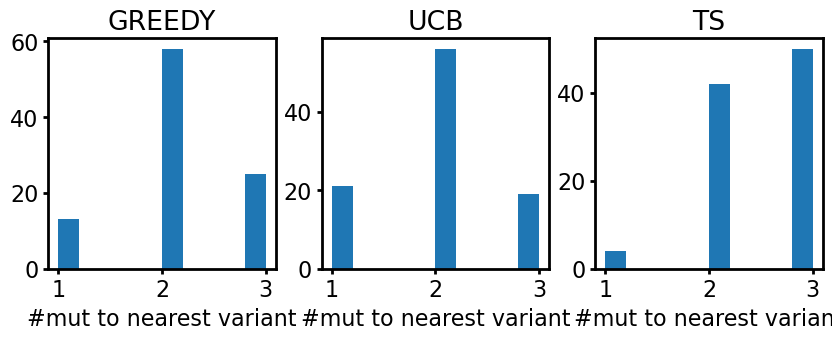

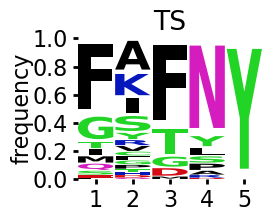

In [3]:
#just to get a mapping from indices to combos
fitness_df = pd.DataFrame()
combos = np.load('results/production/combos.npy')
fitness_df['Combo'] = combos
fitness_df


plt.figure(1, figsize=(10, 3))
counter = 0
for i in [1]:
    for acq in  ['GREEDY', 'UCB', 'TS']:

        # indices = torch.load('/home/jyang4/repos/DKBO-MLDE/results/production_test/DKL_BOTORCH-DO-0-RBF-UCB-[10, 10]_1indices.pt')
        indices= torch.load(f'results/production/test/DNN_ENSEMBLE-DO-0-RBF-{acq}-[30, 1]_1indices.pt')
        #indices= torch.load(f'/disk1/jyang4/repos/DKBO-MLDE/results/production/test/BOOSTING_ENSEMBLE-DO-0-RBF-{acq}-[100, 1]_1indices.pt')
        # indices = torch.load('/home/jyang4/repos/DKBO-MLDE/results/production_test/GP_BOTORCH-DO-0-RBF-UCB-[100, 1]_1indices.pt')

            
        subset = fitness_df.iloc[indices, :].reset_index()
        batch = subset[-96:] #look at the most recent 96

        old_combos = subset[:-96]['Combo']
        #new_combos = fitness_df.iloc[indices[96:192]]['Combo']
        new_combos = batch['Combo']
        min_distances = []
        min_distances_args = []
        for combo1 in new_combos:
            distances = []
            for combo2 in old_combos:
                distances.append(sum([combo1[i] != combo2[i] for i in range(len(combo1))]))
            min_distances.append(min(distances))
            min_distances_args.append(np.argmin(distances))
        
        plt.figure(1)
        plt.subplot(1, 3, counter +1)
        plt.hist(min_distances)
        plt.xlabel('#mut to nearest variant')
        plt.title(acq)

        for l in range(5):
            batch['AA' + str(l+1)] = batch['Combo'].apply(lambda x: x[l])

        # for k, label  in enumerate(['AA1', 'AA2', 'AA3', 'AA4', 'AA5']):

        #     plt.subplot(3, 5, counter+1)
        #     counter += 1
        #     batch[label].value_counts().plot(kind="bar")
        #     #sns.countplot(x=label, data=batch)
        plot_logo(batch, acq)

        counter += 1
    plt.tight_layout()

In [4]:
batch.head(10)

,index,Combo,AA1,AA2,AA3,AA4,AA5
216,710639,FKTNY,F,K,T,N,Y
217,761839,FSFNY,F,S,F,N,Y
218,641839,FAFNY,F,A,F,N,Y
219,697839,FIFNY,F,I,F,N,Y
220,641199,FADYY,F,A,D,Y,Y
221,953839,GYFNY,G,Y,F,N,Y
222,673839,FFFNY,F,F,F,N,Y
223,646799,FATYY,F,A,T,Y,Y
224,761799,FSFLY,F,S,F,L,Y
225,641859,FAFPY,F,A,F,P,Y


### Check if Uncertainty is Calibrated

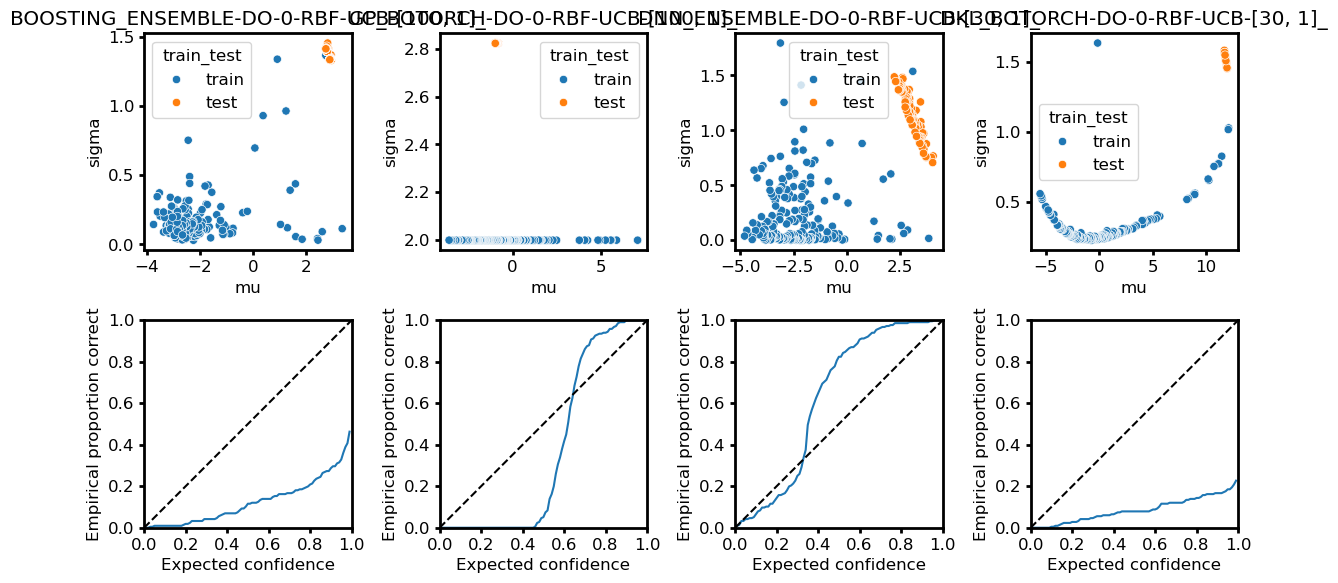

In [16]:
i = 0
plt.figure(1, figsize=(12, 6))
summary_df = pd.DataFrame(columns=['Protein', 'Encoding', 'Model', 'rho', 'miscalibration_area', 'MAE'])
encoding = 'onehot'
protein = 'Pgb'

for model in ['BOOSTING_ENSEMBLE-DO-0-RBF-UCB-[100, 1]_', 'GP_BOTORCH-DO-0-RBF-UCB-[100, 1]_', 'DNN_ENSEMBLE-DO-0-RBF-UCB-[30, 1]_', 'DKL_BOTORCH-DO-0-RBF-UCB-[30, 1]_']:
    directory_prefix = '/disk1/jyang4/repos/DKBO-MLDE/results/production/round1/' + model
    #directory_prefix = '/disk1/jyang4/repos/DKBO-MLDE/results/production/test/DKL_BOTORCH-DO-0-RBF-UCB-[30, 1]_'
    sigma = torch.load(directory_prefix + '1sigma.pt')
    mu = torch.load(directory_prefix + '1mu.pt')
    indices = torch.load(directory_prefix + '1indices.pt').tolist()

    i += 1
    plt.subplot(2, 4, i)
    #add a column with last 96 rows being 'test'
    df = pd.DataFrame({'sigma': sigma[indices], 'mu': mu[indices]})
    df['train_test'] = 'train'
    df.loc[312-96:, 'train_test'] = 'test'
    sns.scatterplot(x='mu', y='sigma', data=df, hue='train_test')
    plt.xlabel('mu')
    plt.ylabel('sigma')
    plt.title(model)

    fitness_df = pd.read_csv('/disk1/jyang4/repos/data/Pgb_fitness.csv')
    fitness_col = 'Diff'
    n_points = 99


    #fitness_df[fitness_col] = fitness_df[fitness_col]/fitness_df[fitness_col].max()
    fitness_df['sigma'] = sigma[indices[:-96]]
    fitness_df['mu'] = mu[indices[:-96]]
    fitness_df[fitness_col] = fitness_df[fitness_col]

    fitness_df['normalized_sigma'] = abs(fitness_df['sigma']/fitness_df['mu'])
    fitness_df['UCB'] = fitness_df['mu'] + 2 * fitness_df['sigma']
    fitness_df['LCB'] = fitness_df['mu'] - 2 * fitness_df['sigma']
    fitness_df['calibrated'] = (fitness_df[fitness_col] > fitness_df['LCB']) & (fitness_df[fitness_col] < fitness_df['UCB'])
    fitness_df['normalized_error'] = abs((fitness_df['mu'] - fitness_df[fitness_col])/fitness_df['mu'])
    fitness_df['error'] = abs((fitness_df['mu'] - fitness_df[fitness_col]))
    fitness_df['MAE'] = (fitness_df['mu'] - fitness_df[fitness_col])**2

    #print(fitness_df['calibrated'].sum()/len(fitness_df))

    #subset = fitness_df.iloc[indices[:96]]

    confidences = np.linspace(0.01, 0.99, n_points)
    y = []
    miscalibration_area = 0
    for confidence in confidences:
        z_score = z_score_for_confidence_interval(confidence)
        #fitness_df = nearby_df only check the similar variants
        #fitness_df = subset
        fitness_df['UCB_temp'] = fitness_df['mu'] + z_score * fitness_df['sigma']
        fitness_df['LCB_temp'] = fitness_df['mu'] - z_score * fitness_df['sigma']
        fitness_df['calibrated_temp'] = (fitness_df[fitness_col] > fitness_df['LCB_temp']) & (fitness_df[fitness_col] < fitness_df['UCB_temp'])
        temp_y = fitness_df['calibrated_temp'].sum()/len(fitness_df)
        y.append(temp_y)
        miscalibration_area += abs(confidence - temp_y) #approximate area as a sum of rectangles
    miscalibration_area /= n_points
    
    sorted = fitness_df.sort_values(by='sigma')
    rho = spearmanr(fitness_df['sigma'], fitness_df['MAE'])[0]
    summary_df.loc[len(summary_df.index)] = [protein, encoding, model, rho, miscalibration_area, sorted['MAE'].mean()]

    plt.subplot(2, 4, i+4)
    mean = y
    p = plt.plot(confidences, mean, '-')
    #sem = all_ys.std(axis=1)
    #plt.fill_between(confidences, mean - sem, mean + sem, color=p[-1].get_color(), alpha=.15)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.plot([0,1], [0,1], '--k')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xticks(np.arange(0, 1.1, 0.2))
    plt.yticks(np.arange(0, 1.1, 0.2))
    plt.xlabel('Expected confidence')
    plt.ylabel('Empirical proportion correct')

plt.tight_layout()

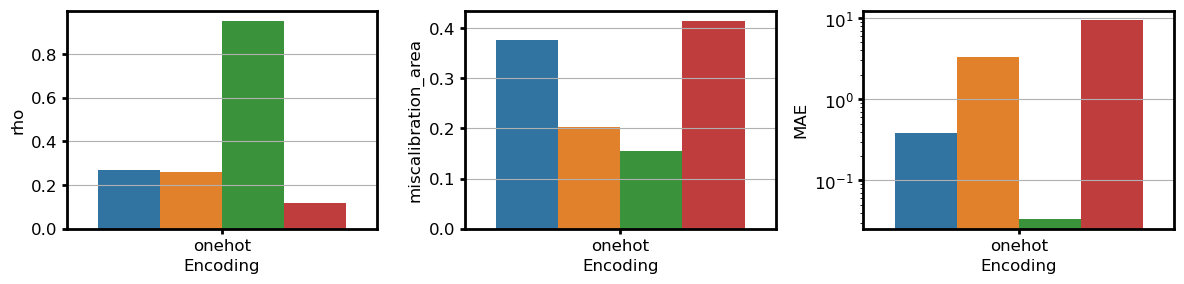

In [19]:
plt.figure(figsize=(12, 3))
i = 0
for metric in ['rho', 'miscalibration_area', 'MAE']:
    i += 1
    plt.subplot(1, 3, i)
    g = sns.barplot(data=summary_df, x='Encoding', y=metric, hue='Model', legend=False)
    if metric == 'MAE':
        g.set_yscale("log")
    g.yaxis.grid(True)
plt.tight_layout()

### Visualize sequence encodings in lower dimensions

In [13]:
from src.encoding_utils import *

In [14]:
combos = np.load('/disk1/jyang4/repos/DKBO-MLDE/results/production/combos.npy')
embeddings = generate_onehot(combos) # onehot, DKL, TS
#embeddings = torch.load('/home/jyang4/repos/data/trpB_onehot_x.pt')
#fitness_df = pd.read_csv('/home/jyang4/repos/data/GB1_fitness.csv')
#embeddings = embeddings.detach().numpy()
embeddings.shape

torch.Size([3200000, 5, 20])

In [15]:
def hamming(combo1, combo2):
    #return number of differences between strings combo1 and combo2
    count = 0
    for i in range(len(combo1)):
        if combo1[i] != combo2[i]:
            count += 1 
    return count

In [16]:
#get indices of combos where first 4 letters are 'WYLQ'
singles = [i for i in range(len(combos)) if hamming(combos[i], 'WYLQF') <= 1]
len(singles)

96

In [17]:
embeddings = embeddings.reshape(embeddings.shape[0], -1)

In [18]:
#PCA transform on embeddings
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(embeddings)
pca_embeddings = pca.transform(embeddings)

/disk1/jyang4/miniconda3/envs/dkbo/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


<Figure size 1200x800 with 0 Axes>

/disk1/jyang4/miniconda3/envs/dkbo/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


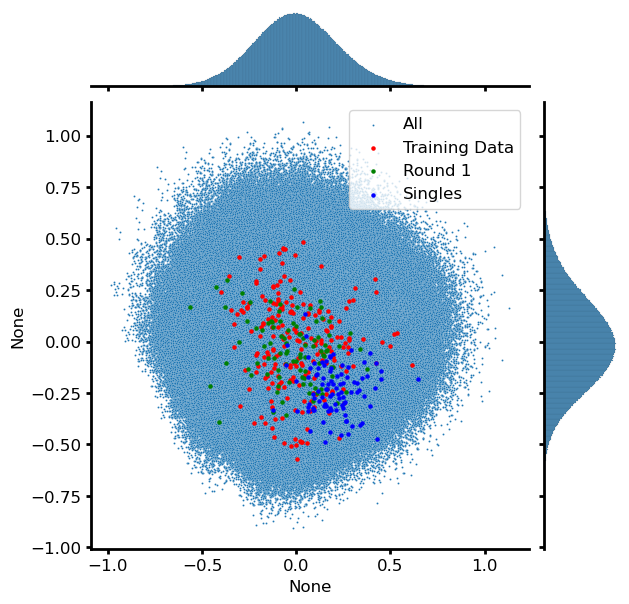

In [20]:
#plot the embeddings
plt.figure(figsize=(12, 8))
#fitness = fitness_df['fit'].values
#reorder the embeddings so they are based on fitness
#indices = np.argsort(fitness)
#sorted_fitness = fitness[indices]
indices = torch.load('/disk1/jyang4/repos/DKBO-MLDE/results/production/round1/DKL_BOTORCH-DO-0-RBF-UCB-[30, 1]_1indices.pt').numpy().astype(int)
#indices = singles

sns.jointplot(x=pca_embeddings[:, 0], y=pca_embeddings[:, 1],s = 2)
plt.scatter(pca_embeddings[indices[:-96], 0], pca_embeddings[indices[:-96], 1],s = 5, c='r')
plt.scatter(pca_embeddings[indices[-96:], 0], pca_embeddings[indices[-96:], 1],s = 5, c ='g')
plt.scatter(pca_embeddings[singles, 0], pca_embeddings[singles, 1],s = 5, c ='b')
#plt.scatter(pca_embeddings[indices, 0], pca_embeddings[indices, 1], c=sorted_fitness, cmap='viridis', s=5)
plt.legend(['All', 'Training Data', 'Round 1', 'Singles'])